# Assignment on Melanoma Detection
                                                             - Vinoda Varshini Rajagopal

## 1. Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

  - Actinic keratosis
  - Basal cell carcinoma
  - Dermatofibroma
  - Melanoma
  - Nevus
  - Pigmented benign keratosis
  - Seborrheic keratosis
  - Squamous cell carcinoma
  - Vascular lesion

## 2. Data Loading

__Importing Packages__

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Mounting the data using google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/Melanoma/CNN_assignment.zip" > /dev/null

In [ ]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing

__Creating a dataset by defining some parameters to the loader__


In [ ]:
#Declaring Batch size and image size
batch_size = 32
img_height = 180
img_width = 180

- Using 80% of the images for training and 20% for validation.

In [ ]:
## train dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="training",seed=123,
                                                               image_size=(img_height, img_width),batch_size=batch_size)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## validation dataset
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="validation",seed=123,
                                                             image_size=(img_height, img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


__Observation__
- From the total of 2239 files, 1792 files were used for training and 447 files were used for validation

## 3.Visualising the data

- Visualising one instance of all the nine classes present in the dataset.

Found 2239 files belonging to 9 classes.


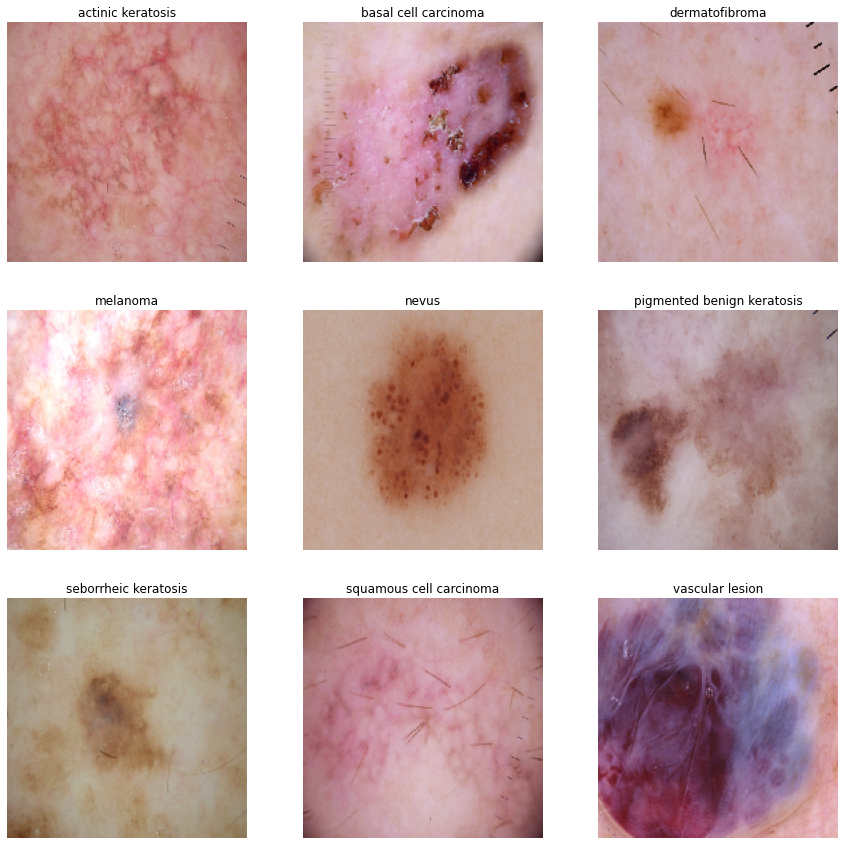

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

__Observation__
- **actinic keratosis, basal cell carcinoma, dermatofibroma, melanoma, nevus, pigmented benign keratosis, seborrheic keratosis, squamous cell carcinoma, vascular lesion**
 are the classes of skin cancer types we have in our data

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# keeps the dataset in memory after they are loaded off disk during the first epoch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) 

# overlaps data preprocessing and model execution while training
validate_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 4. Model Building

## __Model 1__

__Rescaling the images__
- The value of each pixel is between 0-255, so we will rescale each pixel by dividing by 255, so that the range becomes 0-1.

In [ ]:
# Rescaling image
rescale_melanoma = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (rescale_melanoma(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.06960856 1.0


__Create the model__

In [ ]:
### Your code goes here
num_classes = 9

model_1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255), 

  #first layer
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  #second layer
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  
  # flatten and put a fully connected layer
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256,activation='relu'),
   
  # softmax layer
  tf.keras.layers.Dense(num_classes, activation = 'softmax')
])


__Compile the model__

In [ ]:
#Model Compilation 
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

__Train the model__

In [ ]:
## Epochs = 20

epochs = 20
batch_size = 32

history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 14s 86ms/step - loss: 2.4928 - accuracy: 0.3181 - val_loss: 1.5830 - val_accuracy: 0.4698
Epoch 2/20
56/56 [==============================] - 4s 81ms/step - loss: 1.4879 - accuracy: 0.4816 - val_loss: 1.4503 - val_accuracy: 0.5257
Epoch 3/20
56/56 [==============================] - 4s 80ms/step - loss: 1.3759 - accuracy: 0.5173 - val_loss: 1.5006 - val_accuracy: 0.4877
Epoch 4/20
56/56 [==============================] - 4s 79ms/step - loss: 1.2459 - accuracy: 0.5681 - val_loss: 1.4332 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 4s 80ms/step - loss: 1.0689 - accuracy: 0.6194 - val_loss: 1.5133 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 4s 79ms/step - loss: 0.9661 - accuracy: 0.6512 - val_loss: 1.5794 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 4s 81ms/step - loss: 0.8002 - accuracy: 0.7193 - val_loss: 1.6352 - val_accuracy: 0.5190
Epoch 8/20
56/56 [=====

__Visualizing training results__

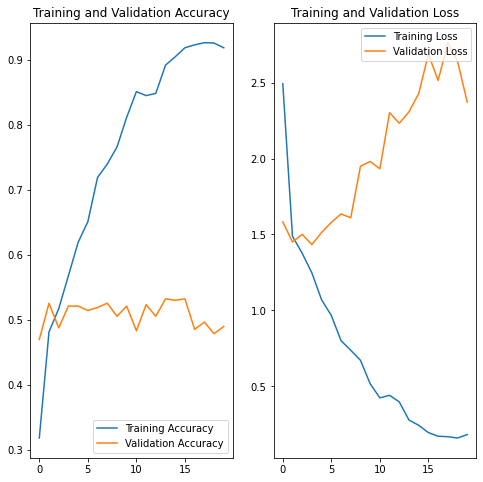

In [ ]:
# Visualizing Model 1
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

__Findings on Model 1__

- Validation accuracy is lower than the training accuracy.
- Validation loss is increasedcompared to training loss.

- **Our model seems to be overfitting**
   Training accuracy = 91% and validation accuracy = 48%

## __Model 2__

__Applying Augmentation__

In [ ]:
# Selecting file for visualizing augmentation
from google.colab import files
upoaded=files.upload()

Saving ISIC_0000144.jpg to ISIC_0000144.jpg


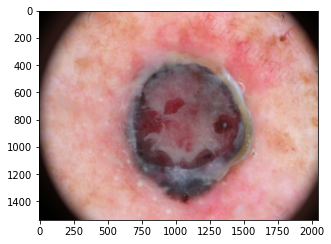

In [ ]:
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
pic = imageio.imread ("ISIC_0000144.jpg")

plt.figure(figsize =(5,5))
plt.imshow(pic)

__Resizing and Rescaling__


In [ ]:
# Applying resizing and rescaling for image
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

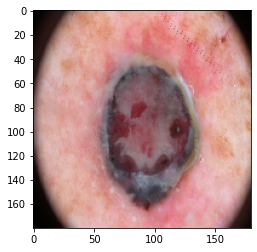

In [ ]:
result = resize_and_rescale(pic)
_ = plt.imshow(result)

In [ ]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())   # Print min and max pixel values

Min and max pixel values: 0.0 0.99346596


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(pic, 0), tf.float32)

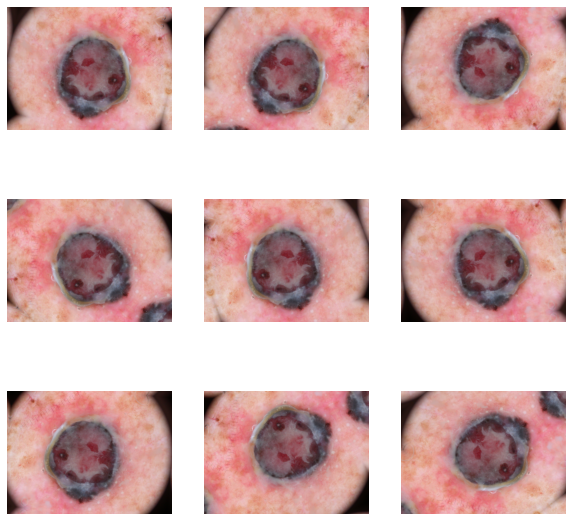

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype('uint8'))
  plt.axis("off")

__Custom Data Augmentation__

In [ ]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [ ]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

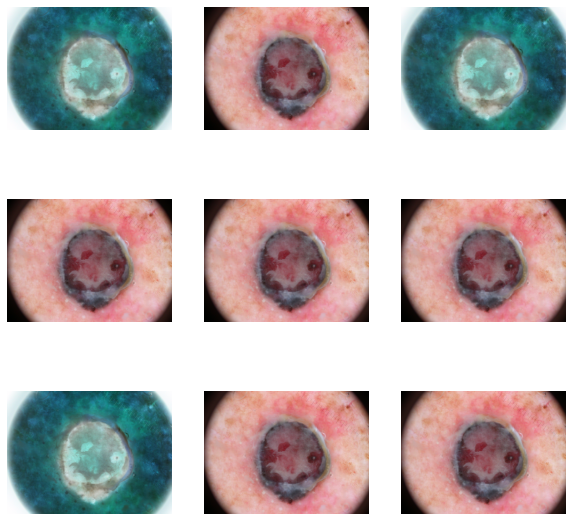

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

__Create the model__

In [ ]:
# Including data_augmentation

### Your code goes here
num_classes = 9

model_2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),  
  # Add the preprocessing layers you created earlier.
  data_augmentation,  
   
  #first layer
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  #second layer
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  #third conv layer
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
   
  #Add Dropout layer (20%)
  tf.keras.layers.Dropout(0.2),  
   
  # flatten and put a fully connected layer
  tf.keras.layers.Flatten(),
   
  #Add Dropout layer (25%)
  #tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu'),

  # softmax layer
  tf.keras.layers.Dense(num_classes, activation = 'softmax')
])


__Compiling the model__

In [ ]:
# Compiling Model 2
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

__Training the model__

In [ ]:
## Epochs = 20
#batch_size = 32

epochs = 20
history = model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 107ms/step - loss: 2.0863 - accuracy: 0.2104 - val_loss: 1.9815 - val_accuracy: 0.2595
Epoch 2/20
56/56 [==============================] - 6s 103ms/step - loss: 1.8537 - accuracy: 0.3030 - val_loss: 1.6548 - val_accuracy: 0.4049
Epoch 3/20
56/56 [==============================] - 6s 102ms/step - loss: 1.6300 - accuracy: 0.4062 - val_loss: 1.6751 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 6s 103ms/step - loss: 1.4850 - accuracy: 0.4788 - val_loss: 1.4510 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 6s 103ms/step - loss: 1.4067 - accuracy: 0.4805 - val_loss: 1.4881 - val_accuracy: 0.4877
Epoch 6/20
56/56 [==============================] - 6s 103ms/step - loss: 1.3607 - accuracy: 0.5095 - val_loss: 1.4695 - val_accuracy: 0.4944
Epoch 7/20
56/56 [==============================] - 6s 104ms/step - loss: 1.3434 - accuracy: 0.5285 - val_loss: 1.4056 - val_accuracy: 0.5324
Epoch 

__Visualizing the results__

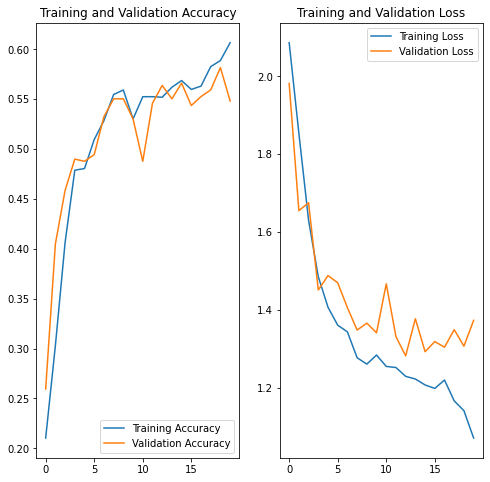

In [ ]:
# Visualizing Model 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

__Observation from Model 2__
- Now, we have resolved overfitting, but the accuracy of our model is very less.
- Training accuracy = 60% and validation accuracy = 54%

__Distrbution of classes in Training dataset__

In [ ]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,squamous cell carcinoma,181
2,seborrheic keratosis,77
3,vascular lesion,139
4,basal cell carcinoma,376
5,nevus,357
6,melanoma,438
7,dermatofibroma,95
8,pigmented benign keratosis,462


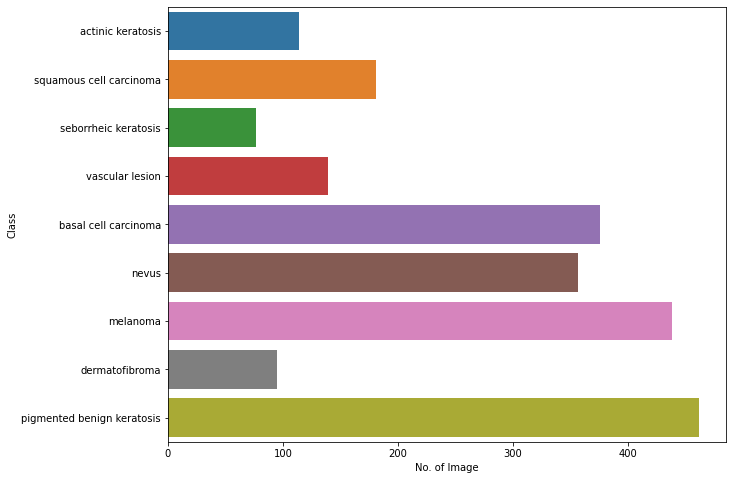

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

__Observation__

- Large number of skin cancer belongs to **pigmented benign keratosis, melanoma, basal cell carcinoma**.
- Which class has the least number of samples?
  - **seborrheic keratosis and dermatofibroma**
- Which classes dominate the data in terms proportionate number of samples?
  - **pigmented benign keratosis, melanoma**
- This leads to class imbalance in the model.

## __Model 3__

In [ ]:
#install Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5BD2E1C710>: 100%|██████████| 500/500 [00:19<00:00, 25.56 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B56E39ED0>: 100%|██████████| 500/500 [00:16<00:00, 29.51 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B56A93E10>: 100%|██████████| 500/500 [00:15<00:00, 31.35 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5BD2E494D0>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F5B6C3AC050>: 100%|██████████| 500/500 [01:23<00:00,  5.99 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5BD2E17BD0>: 100%|██████████| 500/500 [00:15<00:00, 32.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5BD2E34D10>: 100%|██████████| 500/500 [00:37<00:00, 13.42 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5BC05D65D0>: 100%|██████████| 500/500 [00:15<00:00, 32.21 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F5B6C0FDCD0>: 100%|██████████| 500/500 [00:15<00:00, 32.09 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


4500


Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
import shutil

In [ ]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'),recursive=True)]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029713.jpg_2e3fe34f-0071-4fc7-8a42-dfba4b140f20.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031506.jpg_6b3660d2-7ec7-40a6-b9e9-463e87d83325.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029781.jpg_bd0d1cfc-b9c0-423a-88ca-aa6048364113.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_007aafbd-cb42-420e-b275-801f631c75be.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029309.jpg_95beb074-5f92-4848-884d-44afd6276983.jpg',
 '/content/Skin cancer ISIC The International

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train,'output', '*.jpg'),recursive = True)]
lesion_list_new

[]

In [ ]:
path_list_new = path_list

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [ ]:
new_df = df.append(df2)

In [ ]:
new_df['Label'].value_counts()

Series([], Name: Label, dtype: int64)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [ ]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/"

In [ ]:
train_base_dir = path_to_training_dataset.split('Train')[0]
new_train_dir = train_base_dir + "output/"
shutil.copytree(path_to_training_dataset,new_train_dir)

'/content/Skin cancer ISIC The International Skin Imaging Collaboration/output/'

__Train the model on the data created using Augmentor__

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

__Create a training dataset__

In [ ]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


__Create a validation dataset__

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size =(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


__Create your model (make sure to include normalization)__

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
### Your code goes here
num_classes = 9

model_3 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  
  #first layer
  tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  #second layer
  tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  #third layer
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  
  #Fourth Layer
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),

  #Fifth Layer
  tf.keras.layers.Conv2D(256, (3,3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
  tf.keras.layers.MaxPooling2D(),
   
  #Add Dropout layer (30%)
  tf.keras.layers.Dropout(0.3), 
  tf.keras.layers.BatchNormalization(),

   
  # flatten and put a fully connected layer
  tf.keras.layers.Flatten(),
   
  #Add Dropout layer (25%)
  #tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
  
  # softmax layer
  tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

__Compiling the model__

In [ ]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model_3.compile(optimizer="adam",loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])


__Train the model__

In [ ]:
# Train the model with 30 epochs
epochs = 30

history = model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 26s 144ms/step - loss: 2.1120 - accuracy: 0.3001 - val_loss: 2.2864 - val_accuracy: 0.1782
Epoch 2/30
169/169 [==============================] - 24s 139ms/step - loss: 1.7729 - accuracy: 0.3820 - val_loss: 1.9199 - val_accuracy: 0.3816
Epoch 3/30
169/169 [==============================] - 24s 140ms/step - loss: 1.6186 - accuracy: 0.4316 - val_loss: 1.5712 - val_accuracy: 0.4692
Epoch 4/30
169/169 [==============================] - 24s 140ms/step - loss: 1.5279 - accuracy: 0.4557 - val_loss: 1.4842 - val_accuracy: 0.4796
Epoch 5/30
169/169 [==============================] - 26s 149ms/step - loss: 1.4416 - accuracy: 0.4800 - val_loss: 1.4356 - val_accuracy: 0.4878
Epoch 6/30
169/169 [==============================] - 24s 140ms/step - loss: 1.3898 - accuracy: 0.4931 - val_loss: 1.3796 - val_accuracy: 0.5212
Epoch 7/30
169/169 [==============================] - 24s 139ms/step - loss: 1.3163 - accuracy: 0.5432 - val_loss: 1.2774 - val_accuracy: 0.5

__Visualizing training results__

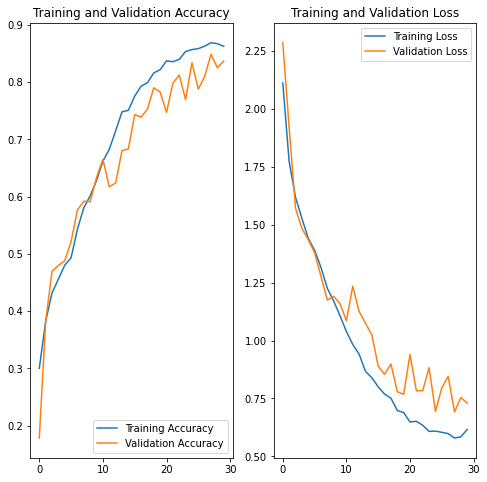

In [ ]:
# Visualizing Model 3
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

__Observation on Model 3__



- Observation on the model after applying regularization and Batch Normalization.
  - **Training Accuracy : 86%**
  - **Validation Accuracy : 83%**
- This model is good enough and more generalizable.

## 5. Conclusion

- **Model 1 - Vanilla Model**
  - Training the model with basic CNN architecture, having 2 hidden layers and applying softmax as activation function.
  - Our model seems to be overfitting **Training accuracy = 91% and validation accuracy = 48%**.
  - Overfitting was due to lack of dropout layers and no data augmentation.

- **Model 2**
  - Model 2 was built on model 1 and adding drop out layers and augmentation.
  - By training Model 2, we got **Training accuracy = 60% and validation accuracy = 54%**.

- **Model 3**
  - Model 3 was built on model 2 and applied augmentor for balancing the class.
  -  Added 500 samples per class to make sure that none of the classes are sparse.
  - Applied Batch Normalization and l2 regularizer.
  - Training model 3 yielded **Training accuracy of 86% and validation accuracy of 83%**.